# Synthetic credit card fraud dataset

## Introduction

For this project I will be looking at a synthetic financial transaction dataset and use it to create a model which is capable of detecting fraudulent transactions. One of the primary difficulties when doing this type of project is finding a good dataset, due to privacy concerns most financial institutions are unwilling to make their datasets publicly available. To overcome this problem some companies have developed methods to generate synthetic datasets, a synthetic dataset is a dataset which contains simulated or sudo transactions. Although none of the transactions have ever taken place the characteristics of the dataset closely resembles genuine transactions.

The particular dataset we are working with was created by a company called PaySim, the dataset contains 10 input variables and 1 binary output variable. In total there are 6362620 transactions in the dataset. We will start off by importing the necessary libraries and the dataset, we will then conduct some exploratory data analysis, them move onto feature engineering and model creation, and finally we will evaluate the model we have created. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [54]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score
%matplotlib inline

### Exploratory data analysis

We start off by looking at the head of the data, we then use the describe and info methods to get a better idea of what we're dealing with. From the info method we can see that we have a combination of float, int and object data types. We can also see from the head of our dataset that we have a lot of zeros in the balance of the origin and destination accounts both before and after the transaction.

We want to further explore this so we look at the amount of zero balances in all of the variables related to account balances. Although not all of the amounts are equal we can see that we have a problem with our dataset. We have an unusually high amount of balances, perhaps this would be understandable if we were only looking at the zero balances of the origin account after the transaction, but we can see that many origin accounts have a zero balance before the transaction occurs. Will wil explore this problem further when we analyse the individual variables and in the feature engineering section.

Another problem that we observe is that the balances between the origin and destination accounts before and after the transaction don't seem to add up properly. For example for the 1st entry in our dataset, if we look at the amount that was transacted and compare it to the old and new balance of the destination account it adds up correctly, however the balance of the destination account does not change. This phenomenon can be seen all throughout the dataset, and thus warrants further investigation.

In [55]:
fraud = pd.read_csv('fraud.csv', delimiter=',')

In [56]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['oldbalanceDest'].loc[fraud.oldbalanceDest == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['oldbalanceOrg'].loc[fraud.oldbalanceOrg == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['newbalanceDest'].loc[fraud.newbalanceDest == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['newbalanceOrig'].loc[fraud.newbalanceOrig == 0].count()))
print("The amount transfers in the dataset :" + str(len(fraud)))

The amount of empty empty destination accounts before the transfer :2704388
The amount of empty empty destination accounts before the transfer :2102449
The amount of empty empty destination accounts before the transfer :2439433
The amount of empty empty destination accounts before the transfer :3609566
The amount transfers in the dataset :6362620


### isFraud

This variable is our binary output variable, it records transactions which were fraudulent. From the plot we can see that the dataset is highly imbalanced, the percentage of fraudulent transactions in the dataset is 0.129%, of the 6362620 transactions in the dataset only 8213 of them are fraudulent.

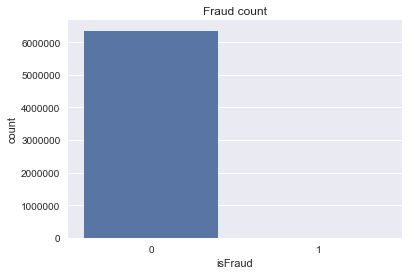

In [8]:
sns.countplot(x="isFraud", data=fraud).set_title('Fraud count')

In [9]:
# Proportion of yes/no

# we'll start off by counting the total number of people who did and didn't subscribe
ycount = fraud['isFraud'].value_counts()
# we need to count the number of total observations
rowcount = fraud.shape[0]-1

print('Proportion of fraud: ' + '{0:2.5f}'.format((ycount[1]/rowcount)))
print('Proportion of genuine: ' + '{0:2.5f}'.format((ycount[0]/rowcount)))

# We'll save the overall proportion of successes as the variable expected, this will help us with our chi squared tests
expected = ycount[1]/rowcount
print('Total instances of fraud ' +str(ycount[1]))

Proportion of fraud: 0.00129
Proportion of genuine: 0.99871
Total instances of fraud 8213


### newbalanceOrig

This variable indicates the balance of the origin account after the transaction. From the newbalanceOrig distribution graph we can see that our dataset is highly skewed. Most transactions in our dataset result in a zero balance of the origin account. We also construct a comparative boxplot graph to look at the difference in distribution of the new balance of the origin account between the fraudulent transactions and the genuine transactions. Although both types have an average balance of almost zero, we can see that the variance for the genuine transactions is much higher. We can see that unlike the genuine transactions, fraudulent transactions almost always result in a zero balance for the originating account.

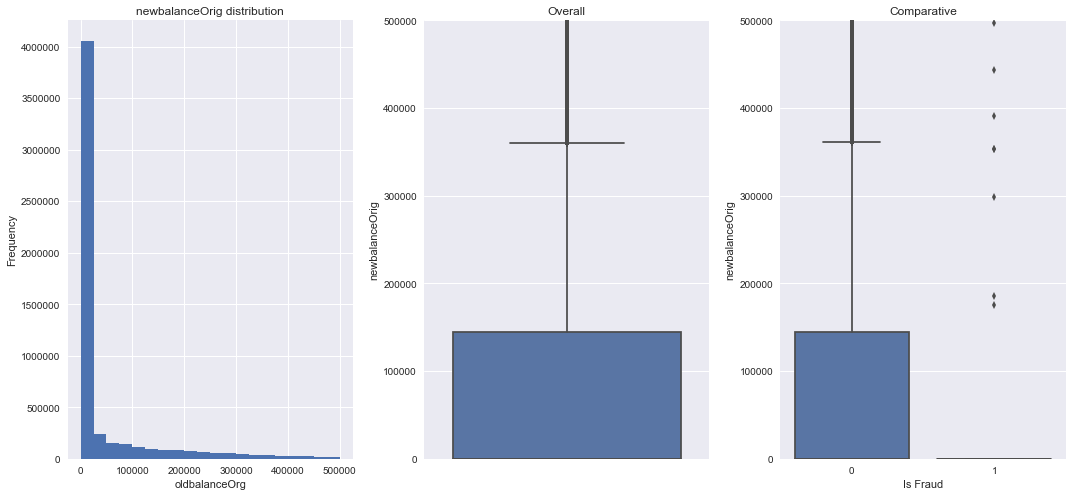

In [10]:
plt.subplot(1, 3, 1)
amountplt = fraud.newbalanceOrig.plot( kind='hist', bins = 20, figsize=(15,7), range=(0,500000))
plt.xlabel('oldbalanceOrg')
plt.title('newbalanceOrig distribution')

plt.subplot(1, 3, 2)
newbalanceOrigbox = sns.boxplot(y="newbalanceOrig", data=fraud)
plt.ylim(0, 500000)
plt.ylabel('newbalanceOrig')
plt.title('Overall')

plt.subplot(1, 3, 3)
newbalanceOrigbox2 = sns.boxplot(x="isFraud", y="newbalanceOrig", data=fraud)
plt.ylim(0, 500000)
newbalanceOrigbox2.set(xlabel='Is Fraud')
plt.title('Comparative')
plt.tight_layout()

### oldbalanceOrg

This variable indicates the balance of the origin account before the transaction. The distribution is fairly typical of bank account balances, most account have very little money in them, but a small number of account hold a very large amount of money. We can see an important trend in the oldbalanceOrg distribution graph, there is a large disparity in the distribution of the fraudulent transactions compared to the genuine transactions. It seems that fraudsters are targeting accounts with larger balances. This is quite helpful to us since we can infer that this variable will be predictive of fraud, i.e. originating accounts with higher balances are more likely to be involved in fraud. This makes intuitive sense since fraudsters are motivated by financial gain, it makes sense that they target account with large balances.

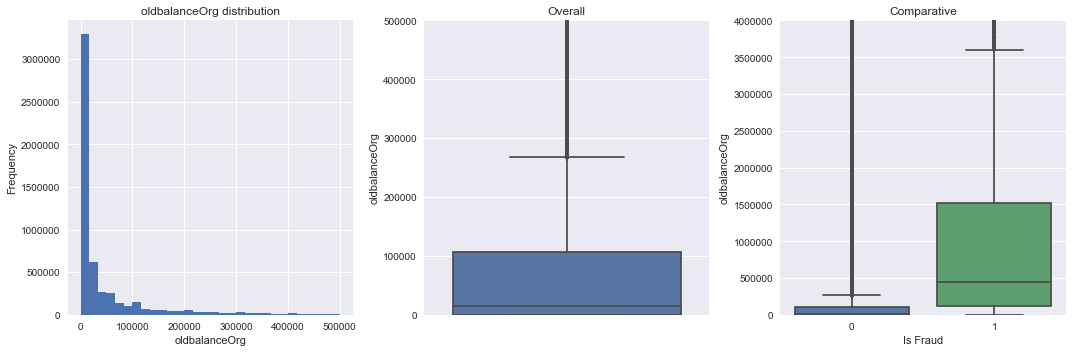

In [11]:
plt.subplot(1, 3, 1)
amountplt = fraud.oldbalanceOrg.plot( kind='hist', bins = 30, figsize=(15,5), range=(0,500000))
plt.xlabel('oldbalanceOrg')
plt.title('oldbalanceOrg distribution')

plt.subplot(1, 3, 2)
oldbalanceOrgbox = sns.boxplot(y="oldbalanceOrg", data=fraud)
plt.ylim(0, 500000)

plt.ylabel('oldbalanceOrg')
plt.title('Overall')


plt.subplot(1, 3, 3)
oldbalanceOrgbox2 = sns.boxplot(x="isFraud", y="oldbalanceOrg", data=fraud)
plt.ylim(0, 4000000)
oldbalanceOrgbox2.set(xlabel='Is Fraud')
plt.title('Comparative')
plt.tight_layout()

### Amount

Represents the amount of money which was transacted. We observe a very similar pattern to the old balance of the origin account, we have a distribution that is highly to the right. From the comparative chart we can see that genuine transactions tend to involve smaller amount of money, whereas fraudulent transactions tend to involve larger amounts of money. Once again this is extremely helpful, we now know that fraudster tend to target accounts with high balances, and they tend to transfer large amounts of money in comparison to genuine transactions.

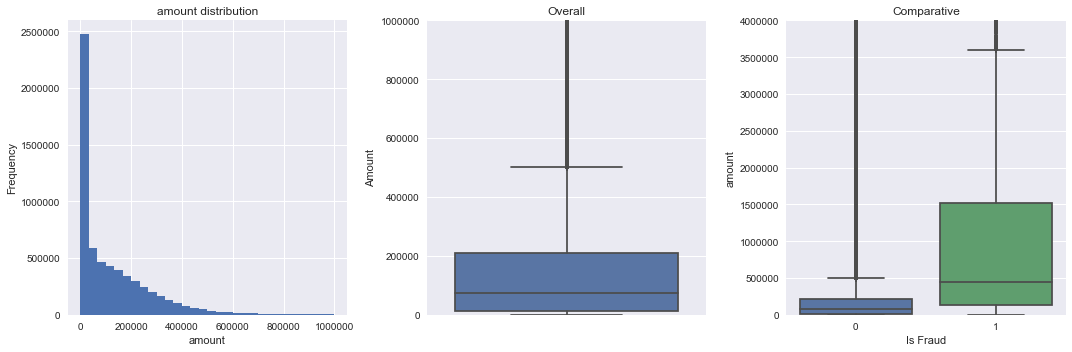

In [12]:
plt.subplot(1, 3, 1)
amountplt = fraud.amount.plot( kind='hist', bins = 30, range=(0,1000000), figsize=(15,5))
plt.xlabel('amount')
plt.title('amount distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="amount", data=fraud)
plt.ylim(0, 1000000)
plt.ylabel('Amount')
plt.title('Overall')

plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="isFraud", y="amount", data=fraud)
plt.ylim(0, 4000000)
stepbox2.set(xlabel='Is Fraud')
plt.title('Comparative')
plt.tight_layout()

### newbalanceDest

Is the balance of the destination account after the transaction. From the newbalanceDest distribution graph we can see that the distribution of the balances is skewed towards the right. However unlike the two previous variables, we can see that the balance of the destination account is much lower than that of the genuine transactions. It seems as though the fraudsters are draining their victims accounts, compared to the genuine transactions where more money is left in the account.

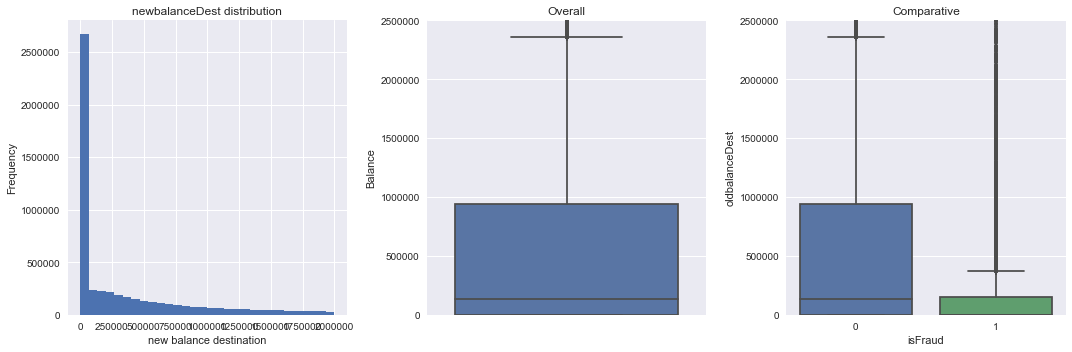

In [13]:
plt.subplot(1, 3, 1)
newbalanceDestplt = fraud.newbalanceDest.plot( kind='hist', bins = 30, figsize=(15,5), range=(0,2000000))
plt.xlabel('new balance destination')
plt.title('newbalanceDest distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="oldbalanceDest", data=fraud)
plt.ylim(0, 2500000)
#stepbox.set_yscale('log')
plt.ylabel('Balance')
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(y="oldbalanceDest", x="isFraud", data=fraud)
plt.ylim(0, 2500000)
#stepbox2.set_yscale('log')
plt.xlabel=('outcome')
plt.title('Comparative')
plt.tight_layout()

### Type

Is the type of transaction which occurred. From the Transaction type chart we can see cashouts are the most common type of transfer and, transfers are the second least common type of transaction. However when we observe the ### chart which shows us the type of transactions that resulted in fraud, we can see that both types of transactions resulted in a comparable amount of fraud, from this we can deduce that transfers have the highest probability of resulting in fraud.

We can also see that only transfers and cashouts result in fraud. This is helpful to us since we can essentially ignore the other transaction types when we create our model. Although this may sound suboptimal, there isn't much use keeping the other types of transactions in the model although it would be nice to be able to create a model capable of differentiating between genuine and fraudulent payments or debits, since we have no no data relating to frauds of those types, we essentially have no data to train our model on.

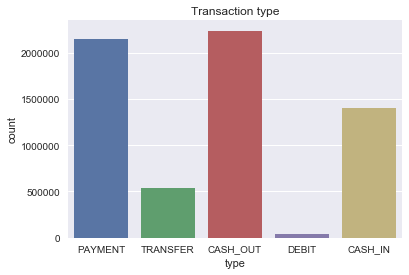

In [14]:
sns.countplot(x="type", data=fraud).set_title('Transaction type')

Here are the transfers which were fraudulent, sorted by type

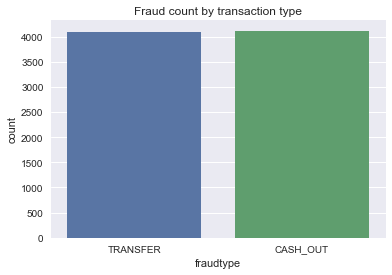

In [15]:
fraud['fraudtype'] = fraud['type'].loc[fraud.isFraud == 1]
sns.countplot(x="fraudtype", data=fraud).set_title('Fraud count by transaction type')

### Step

This variable represents a one hour step during the 31 day month. We can see from the step distribution chart that the transactions are not uniformly distributed across the month, this is interesting as we would expect transactions to be more uniformly distributed across the days. It seems that a majority of the transactions of the transactions occurred during the first half of the month.

It is also interesting see how the distribution of the genuine transactions varies from the fraudulent ones. From the ### chart we can see that on average the fraudulent transactions occurred later in the month. Since there is a large difference in distributions, it may be a possible area that we could explore in our feature engineering section, since there may be some extra information that we can extract from this variable.


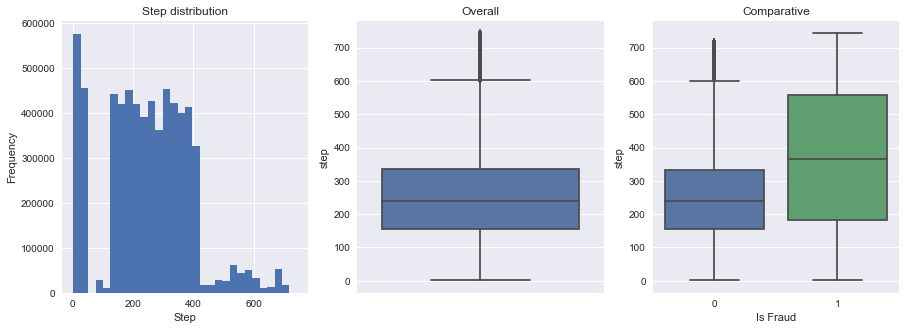

In [21]:
plt.subplot(1, 3, 1)
stepplt = fraud.step.plot( kind='hist', bins = 30, figsize=(15,5))
plt.title('Step distribution')
stepplt.set(xlabel='Step')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="step", data=fraud)
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="isFraud", y="step", data=fraud)
stepbox2.set(xlabel='Is Fraud')
plt.title('Comparative')

### oldbalanceDest

Is the balance of the destination account before the transaction. From the oldbalanceDest distribution chart on the left we can see that the balances are heavily skewed to the right. From the comparison chart we can also see that there is a significant difference in the distribution of the balances between the fraudulent and genuine transactions. THis would seem to indicate that it will have some predictive value.

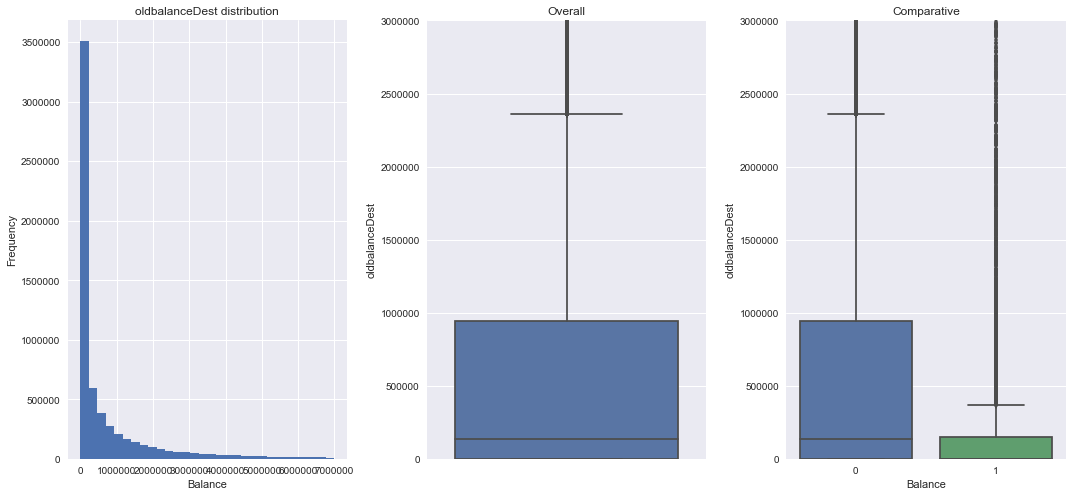

In [23]:
plt.subplot(1, 3, 1)
oldbalanceDestplt = fraud.oldbalanceDest.plot(kind='hist', bins = 30, figsize=(15,7), range=(0,7000000))
oldbalanceDestplt.set(xlabel='Balance')
plt.title('oldbalanceDest distribution')


plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="oldbalanceDest", data=fraud)
plt.ylim(0, 3000000)
plt.ylabel('oldbalanceDest')
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(y="oldbalanceDest", x="isFraud", data=fraud)
plt.ylim(0, 3000000)
stepbox2.set(xlabel='Balance')
plt.title('Comparative')
plt.tight_layout()

## Feature engineering and Data cleaning

We will begin by engineering some new features. The first feature we will develop is an feature that records the hour of the day in which the transaction took place. The reason we do this is because there may be a difference between when the fraudulent and genuine transactions take place. Since we already have a variable that records the hour of the month that the transaction takes place we can simply perform modulo division on this value to calculate the hour of the day in which the transaction took place.

The second feature we create is one which records the theoretical the balance of the origin and destination accounts. Since we know the balance of the destination account before the transfer, and we know the amount being transferred, we can easily calculate the net balance of the destination account account, the same logic applies to the origin account. However when we look at the data we can see that the new balance is not what we expect, in many cases the new balance is either zero, or it doesn't match what it should have been. Thus by recording theoretical account balances we hope that it will provide our model with a new feature to learn on, and thus allow it to make better predictions. Please note that I was not the person who discovered this feature, all credit should go to Arjun Joshua, who's analysis of the data set can be found here:

https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services

In [57]:
# Create hours feature to record the hour in which the transaction occoured
fraud["hours"] = fraud["step"].apply(lambda x: x%24)

In [58]:
# Create hours feature to record the balance that the origin and distination accounts should have had
fraud['errorBalanceOrig'] = fraud.newbalanceOrig + fraud.amount - fraud.oldbalanceOrg
fraud['errorBalanceDest'] = fraud.oldbalanceDest + fraud.amount - fraud.newbalanceOrig

### Data cleaning

There are a number of steps which we have had to take to get the dataset in a form that can be used by our machine learning algorithms, they are as follows:
- Remove the transactions which were of type payment, debit, and cash in. The reason for this is that we have observed no incidents of fraud for these types of transactions, and thus our model won't be able to learn anything from this data
- Use a label encoder to encode the categorical variables with numeric placeholders
- Resample the dataset so that it is less imbalanced. To do this we take a sample of 500,000 genuine transactions and concatenate it with the 8213 incidents of fraud.


In [59]:
# Resample the data so that we only keep transactions of type transfer and cash out
fraud = fraud.loc[(fraud.type == 'TRANSFER') | (fraud.type == 'CASH_OUT')]

In [60]:
# Use label encoder to encode categorical variables
lb_make = LabelEncoder()

categories = ['type', 'nameOrig', 'nameDest']
for col in categories: 
    fraud[str(col)+"_code"] = lb_make.fit_transform(fraud[col]) 

In [61]:
# Resample the data so that we have less genuine transactions in our dataset (500000:8213 genuine to fradulent)
isfraud = fraud.loc[fraud['isFraud']==1]
notfraud = fraud.loc[fraud['isFraud']==0].sample(500000)
resample = pd.concat([isfraud, notfraud])

In [64]:
# Split the data into input and output variables
X = resample.drop(['isFraud', 'isFlaggedFraud', 'type', 'nameOrig', 'nameDest'], axis=1)
y = resample['isFraud']

## Model Creation

Using our dataset we will attempt to build a classification model which is able to differentiate between genuine and fraudulent transactions. We will start off by training a simple model which will act as a baseline for our more complex model. For our baseline will will use a K nearest neighbours (KNN) classifier, and four our more complex model we will use XGBoost.

To evaluate the strength of our models we will use the mean average precision metric (MAP). The reason we use this metric is two fold. Firstly MAP is good at dealing with imbalanced datasets, since we have such a large imbalance in the outcome variable more rudimentary approaches such as accuracy will be not as useful for evaluating how well our model is performing. Secondly we want to use a metric that will be biased towards a positive outcome, in our case this is the transactions which are fraudulent. Models which have high MAP scores will have good precision and recall, which in our case is very importance since we want to don't want to create too much work for the bank by flagging too many transactions as potentially fraudulent, but on the other hand we don't want to miss too many fraudulent transactions.

To train our KNN algorithm it will be helpful to reduce the amount of input variables in the dataset. I have chosen to keep the amount, step, old balance of the destination account, theoretical balance of the origin account and the new balance of the origin account variables. We then split the dataset into a training and testing split, and train our model.

We split the data into a testing and training set, and then convert the data frames into a dmatrix (data structure optimised for XGBoost)

In [31]:
Z = X[['amount', 'step', 'oldbalanceDest', 'errorBalanceOrig', 'newbalanceOrig']]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

In [33]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
preds = knn.predict(X_test)

In [36]:
average_precision_score(y_test, preds)

0.86876114894512346

The MAP of our model is already quite good. And it will serve as a good baseline to asses the predictive power of our XGBoost model.

#### XGBoost

We create a new test train split, this time with all of the input variables. We then convert the data into a DMatrix, this is a data structure that is optimised for the XGBoost algorithm.

We then do some hyperparameter tuning using a grid search, unfortunately due to my limited hardware I was unable to do extensive hyper parameter tuning. THis forced me to only tune parameters which I knew would lead to the biggest increase in model score.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [ ]:
param_test = {
    'max_depth':[3, 5],
    'learning_rate':[0.07, 0.1]
}

gsearch = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=260, objective= 'reg:logistic', nthread=4, seed=42), 
param_grid = param_test, scoring='roc_auc', n_jobs=4, iid=False, cv=10)
gsearch.fit(X_train,y_train)

In [46]:
gsearch.best_params_, gsearch.best_score_

({'learning_rate': 0.07, 'max_depth': 3}, 0.99954108034282307)

Now that we have found the ideal hyper parameters for the model, we want to look at how successive rounds of boosting affect the models accuracy. To do this we build a graph to show how each successive round of boosting alters the models performance. For this test we use K folds cross validation, for our test we use 10 folds.

In [34]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate":0.07, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, num_boost_round=400, as_pandas=True, metrics='map', nfold=10, seed=42)
results = pd.DataFrame(cv_results)
results['round'] = range(1, len(results) + 1)

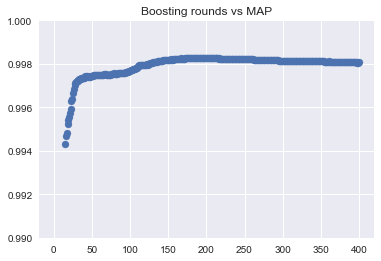

In [37]:
rounds = plt.scatter(results['round'], results['test--mean'])
plt.ylim(0.99, 1)
#rounds.set(xlabel='Number of boosting rounds')
#rounds.set(ylabel='MAP')
plt.title('Boosting rounds vs MAP')

From the graph above we can see that MAP peaks at around 0.9982 after approximatly 200 rounds of boosting, after this model starts to overfit the training data, leading to a decrease in the MAP score on the test data.

Now that we know the ideal number of boosting rounds we perform a final round of cross validation using the ideal hyper parameters and ideal number of boosting rounds to derive an exact MAP for our model.

In [39]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate":0.07, "subsample":0.91, "colsample_bytree":0.95}
    
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, metrics="map", as_pandas=True, num_boost_round=200, nfold=10, seed=42)
print(cv_results[-10:])

     test--mean  test--std  train--mean  train--std
190    0.998211   0.002133     0.999586    0.000069
191    0.998211   0.002132     0.999594    0.000067
192    0.998210   0.002137     0.999598    0.000069
193    0.998210   0.002135     0.999603    0.000069
194    0.998216   0.002130     0.999611    0.000068
195    0.998217   0.002133     0.999619    0.000066
196    0.998217   0.002134     0.999625    0.000065
197    0.998225   0.002124     0.999630    0.000067
198    0.998224   0.002121     0.999636    0.000068
199    0.998226   0.002122     0.999640    0.000068


From the above table we can see that after 200 rounds of boosting we are able to achieve a MAP of 0.998226. Although the model is much more complex than our KNN classifier, the increase in accuracy is likely to be worth the added complexity. Thus I will use this XGBoost model for the model evaluation.

## Model evaluation

Until now we have not looked at the 20% of the dataset which we set asside for the model testing. So to evaluate the predictive power of the model we will fit the model to the testing data and graph the results.

In [67]:
clf = xgb.XGBClassifier(max_depth = 3, n_estimators=200, objective="reg:logistic", learning_rate=0.07, subsample=0.91, colsample_bytree=0.95)

In [68]:
clf.fit(X_train, y_train)
probabilities = clf.predict_proba(X_test)

In [69]:
probabilities =pd.DataFrame(probabilities)

In [70]:
xg_cl = xgb.XGBClassifier(objective="reg:logistic", n_estimators=120, learning_rate=0.069, subsample=0.8, colsample_bytree=0.95, max_depth=3, seed=27, gamma=0.12)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict_proba(X_test)

In [71]:
preds = pd.DataFrame(preds)
y_test = pd.DataFrame(y_test)
preds['number'] = range(1, len(preds) + 1)
y_test['number'] = range(1, len(y_test) + 1)
result = pd.merge(preds, y_test, on="number")

In [72]:
result = result.sort_values(by=[1], ascending=False)
result['number'] = range(1, len(y_test) + 1)

In [73]:
total_yes = result['isFraud'].sum()
recall = []
calls = []

for x in range(len(result)):
    rec = result['isFraud'][:x].sum()/total_yes
    called = x/len(result)
    recall.append(rec)
    calls.append(called)
    
result['recall'] = recall
result['called'] = calls
result.to_csv("results.csv")

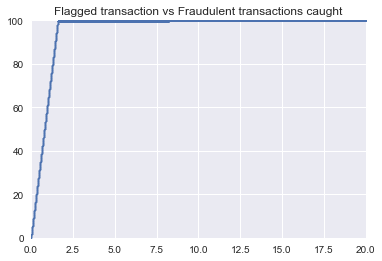

In [74]:
ax = plt.scatter(result['called']*100, result['recall']*100, s=1)
#ax.set_xlabel('Flagged transactions')
#plt.ylabel('Fraudulent transactions caught (')
plt.title('Flagged transaction vs Fraudulent transactions caught')
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.figsize=(15,15)

From the graph above we can see how well our model did at flagging transactions as fraudulent, initially our model was able to catch 99.8% of the fraudulent transactions. However after that we would have needed to flag almost 100% of the transactions to be able to catch 100% of the fraudulent transactions. This is a good example of the precision recall tradeoff, if we want to catch 100% of the fraudulent transactions we will need to investigate approximately 8% of the transactions, whereas to have a high precision we only want to flag about 1.9% of the transactions.

We will also construct a graph to show the feature importances. From it we can see that the hours feature that we created was only mildly predictive of fraud. However the feature which we created which recorded the new theoretical balance of the origin account was highly predictive of fraud.

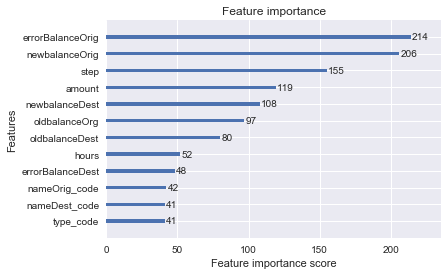

In [48]:
model = xgb.train(params=params, dtrain=dmatrix, num_boost_round=200)
xgb.plot_importance(model, xlabel='Feature importance score',)
plt.show()

## Insights and conclusion

From our analysis of the dataset we saw a number of trends which were predictive of fraud. The biggest trend that we saw was that fraudulent transactions occur exclusively with cashouts and transfers. We also saw how fraudulent transactions tend to involve large amounts of money, and that the transactions tend to result in a zero balance for the originating account.

We also saw how machine learning models can be trained for predicting fraudulent financial transactions. After suitable data preparation our XGBoost model did a respectable job of flagging fraudulent transactions. It could serve as a prototype for future model development. However for a production model to be developed a number of changes would need to be made. Firstly, we were able to achieve a good deal of accuracy be resampling the dataset, although this lead to good model accuracy, it may not be so good in a production model. The reason that we were able to do this is that we knew beforehand which transactions were fraudulent and which were not, however in a production setting this would not be viable. To overcome this we would need to either create a model which is capable of dealing with such an imbalanced dataset, or we would need to develop a system which would allow us to resample the transaction data before feeding it into our model.

The second thing that would need to be investigated is how well our model scales with increased amounts of data. Since production models will need to be able to deal with lots of data, we need to know that the model will scale well. Although our prototype was to model the data in under three minutes, we would need to investigate whether or not the model is able to deal with large transaction volumes in an acceptable amount of time.

Finally we were able to visualise the tradeoff between precision and recall. Essentially what this tradeoff forces us to do is make a decision about where we set our decision boundary. By this I mean, at what level of probability do we flag a transaction as potentially fraudulent? If the threshold is set too low we will do a good job of catching all of the fraudulent transactions, however our precision will suffer, meaning that we will be examining many non-fraudulent transactions. Conversely by setting the threshold too high we will not have to investigate many transactions, yet we will miss many of the transactions which are fraudulent. However this is more of a management question rather than a data science question, as there is no optimal threshold, rather it is dependent of the needs of the business.